In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, brier_score_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Data Exploration and Preprocessing

In [3]:
df = pd.read_csv('data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv')
df 

ID Gender   Race Age_at_Release  Residence_PUMA Gang_Affiliated  \
0          1      M  BLACK          43-47              16           False   
1          2      M  BLACK          33-37              16           False   
2          3      M  BLACK    48 or older              24           False   
3          4      M  WHITE          38-42              16           False   
4          5      M  WHITE          33-37              16           False   
...      ...    ...    ...            ...             ...             ...   
25830  26756      M  BLACK          23-27               9           False   
25831  26758      M  WHITE          38-42              25           False   
25832  26759      M  BLACK          33-37              15           False   
25833  26760      F  WHITE          33-37              15             NaN   
25834  26761      M  WHITE          28-32              12           False   

       Supervision_Risk_Score_First Supervision_Level_First  \
0                               3.0                Standard   
1                               6.0             Specialized   
2                               7.0                    High   
3                               7.0                    High   
4                               4.0             Specialized   
...                             ...                     ...   
25830                           5.0                Standard   
25831                           5.0                Standard   
25832                           5.0                Standard   
25833                           5.0                Standard   
25834                           5.0                Standard   

             Education_Level Dependents  ... DrugTests_Meth_Positive  \
0      At least some college  3 or more  ...                0.000000   
1       Less than HS diploma          1  ...                0.000000   
2      At least some college  3 or more  ...                0.166667   
3       Less than HS diploma          1  ...                0.000000   
4       Less than HS diploma  3 or more  ...                0.058824   
...                      ...        ...  ...                     ...   
25830  At least some college          1  ...                0.000000   
25831  At least some college  3 or more  ...                0.000000   
25832  At least some college  3 or more  ...                     NaN   
25833  At least some college  3 or more  ...                0.000000   
25834    High School Diploma  3 or more  ...                0.000000   

      DrugTests_Other_Positive Percent_Days_Employed Jobs_Per_Year  \
0                          0.0              0.488562      0.447610   
1                          0.0              0.425234      2.000000   
2                          0.0              0.000000      0.000000   
3                          0.0              1.000000      0.718996   
4                          0.0              0.203562      0.929389   
...                        ...                   ...           ...   
25830                      0.0              0.189507      0.572044   
25831                      0.0              0.757098      0.576104   
25832                      NaN              0.711138      0.894125   
25833                      0.0              0.000000      0.000000   
25834                      0.0              0.124454      0.398745   

      Employment_Exempt Recidivism_Within_3years Recidivism_Arrest_Year1  \
0                 False                    False                   False   
1                 False                     True                   False   
2                 False                     True                   False   
3                 False                    False                   False   
4                 False                     True                    True   
...                 ...                      ...                     ...   
25830             False                     True                    True   
25831         

In [10]:
#Importantly, there is a lot of missing data
#in the drug test section, but I think I will drop it, because the drug test data could be useful later
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25835 entries, 0 to 25834
Data columns (total 54 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 25835 non-null  int64  
 1   Gender                                             25835 non-null  object 
 2   Race                                               25835 non-null  object 
 3   Age_at_Release                                     25835 non-null  object 
 4   Residence_PUMA                                     25835 non-null  int64  
 5   Gang_Affiliated                                    22668 non-null  object 
 6   Supervision_Risk_Score_First                       25360 non-null  float64
 7   Supervision_Level_First                            24115 non-null  object 
 8   Education_Level                                    25835 non-null  object 
 9   Depend

In [4]:
df = df.dropna()
df = df.drop('Recidivism_Arrest_Year1', axis=1)
df = df.drop('Recidivism_Arrest_Year2', axis=1)
df = df.drop('Recidivism_Arrest_Year3', axis=1)
print("Number of rows in data file after removing rows with missing values:", df.shape)

Number of rows in data file after removing rows with missing values: (14170, 51)


In [5]:
#Define train and test sets, given that they were already provided for the competition:
#Split the target and the inputs
y = 1*df['Recidivism_Within_3years'] 
train_flag = df['Training_Sample'].values 

X_train = df.loc[df['Training_Sample'] == True]
y_train = 1*df.loc[df['Training_Sample'] == True]['Recidivism_Within_3years'].values
X_test = df.loc[df['Training_Sample'] == False]
y_test = 1*df.loc[df['Training_Sample'] == False]['Recidivism_Within_3years'].values
print("Size of training set: ", len(X_train))
print("Size of test set:", len(y_test))

Size of training set:  9838
Size of test set: 4332


# Encoding

In [6]:

object_cols = df.select_dtypes(include=['object']).columns
df_dummies = df
# Get dummies for object columns
dummies = pd.get_dummies(df_dummies[object_cols], drop_first=True)

# Drop object columns from original df
df_dummies = df_dummies.drop(object_cols, axis=1)

# Concatenate dummies to original df
df_dummies = pd.concat([df_dummies, dummies], axis=1)

In [7]:
#Define train and test sets, given that they were already provided for the competition:
#Split the target and the inputs
train_flag = df['Training_Sample'].values 

X_train_enc = df_dummies.loc[df['Training_Sample'] == True]
X_test_enc = df_dummies.loc[df['Training_Sample'] == False]
print("Size of training set: ", len(X_train))
print("Size of test set:", len(X_test))

Size of training set:  9838
Size of test set: 4332


In [8]:
#Now make sure we drop the target from all of these
X_train_enc = X_train_enc.drop('Recidivism_Within_3years', axis=1)
X_test_enc = X_test_enc.drop('Recidivism_Within_3years', axis=1)
X_train = X_train.drop('Recidivism_Within_3years', axis=1)
X_test = X_test.drop('Recidivism_Within_3years', axis=1)

# One Dimensional Data Exploration

In [66]:
#classes are a bit inbalanced
print("Class Balance Stats")
print(df['Recidivism_Within_3years'].value_counts())

Class Balance Stats
True     8423
False    5747
Name: Recidivism_Within_3years, dtype: int64


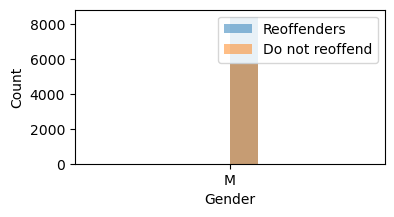

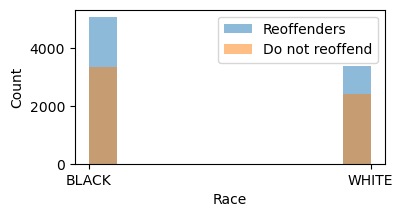

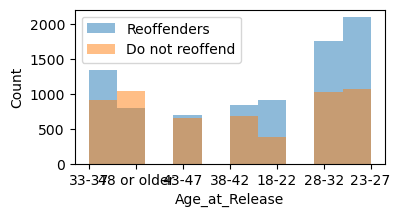

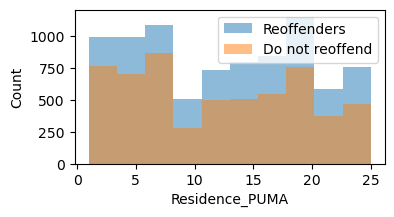

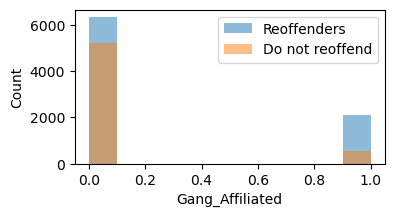

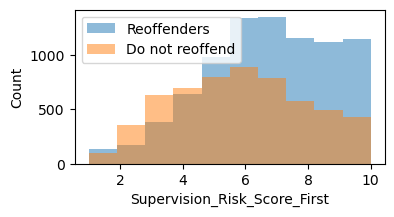

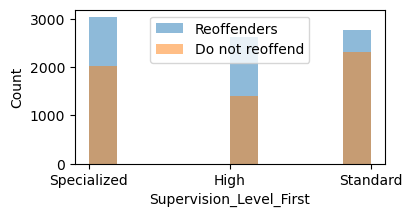

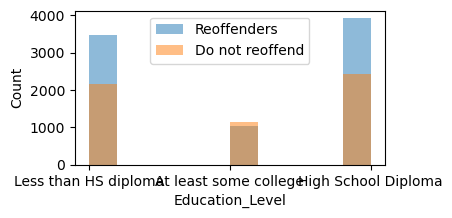

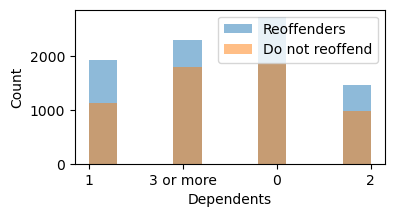

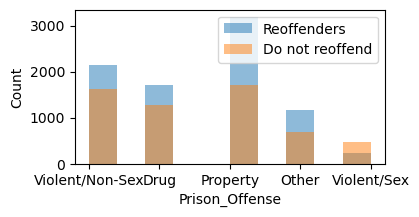

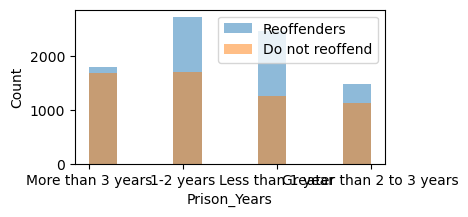

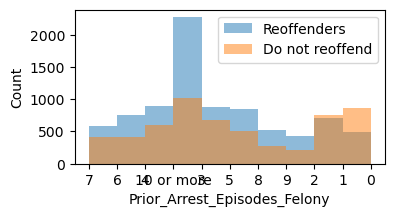

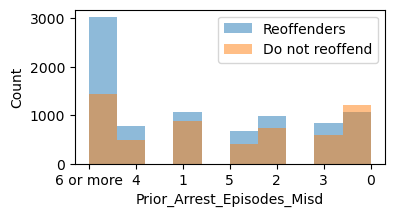

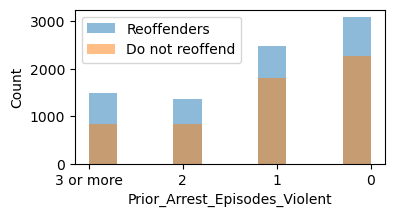

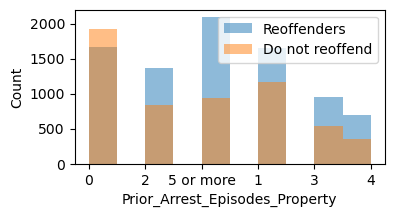

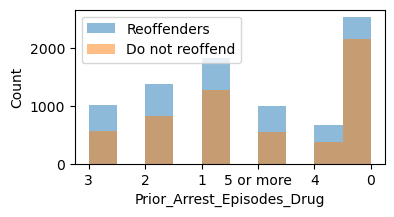

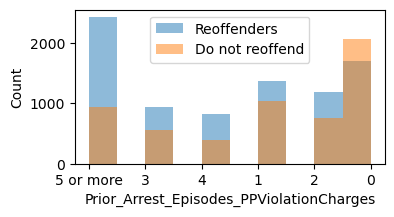

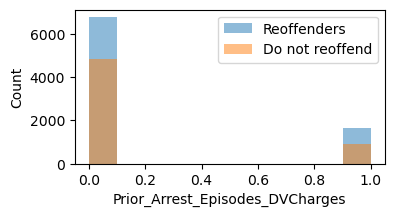

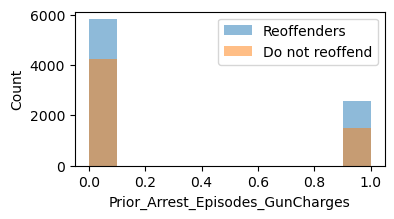

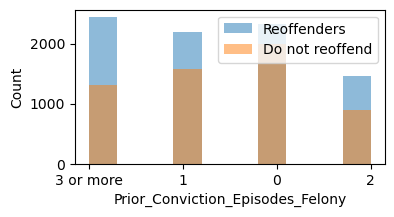

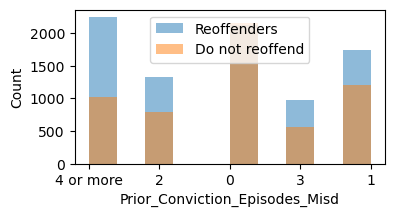

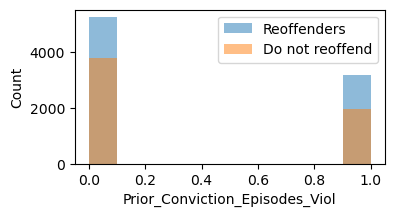

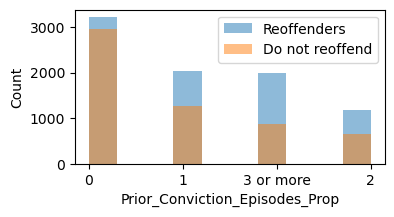

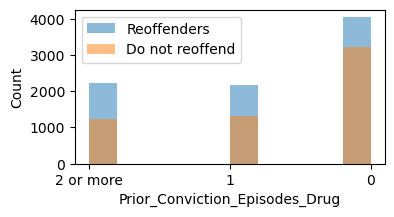

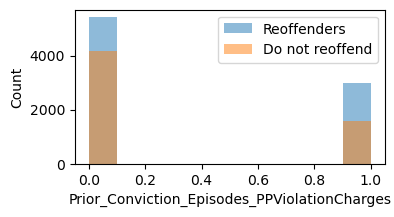

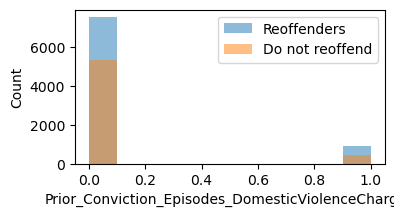

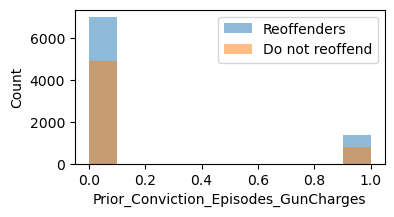

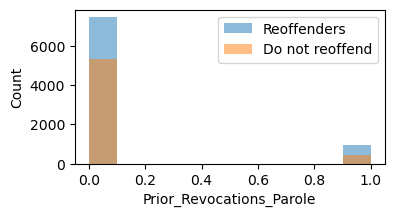

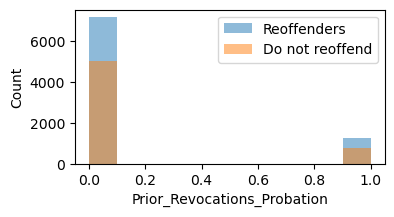

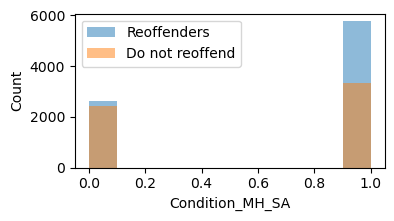

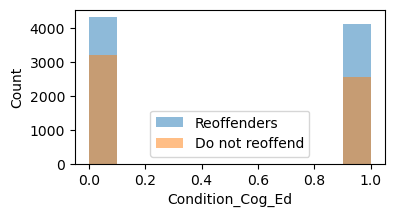

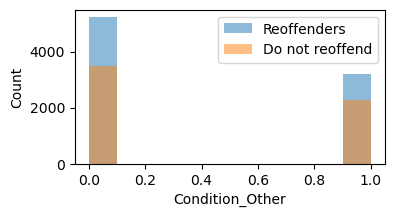

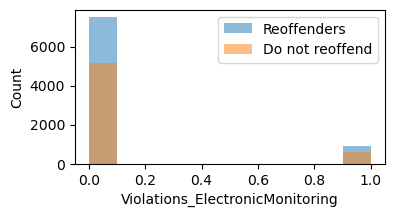

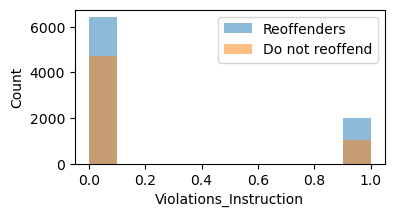

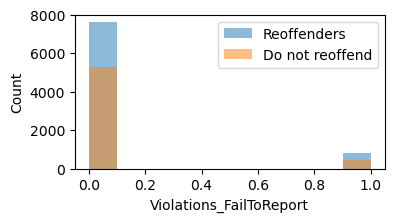

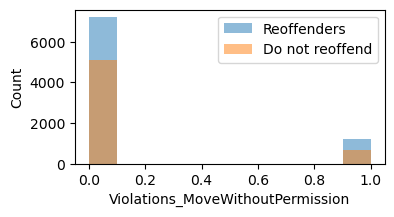

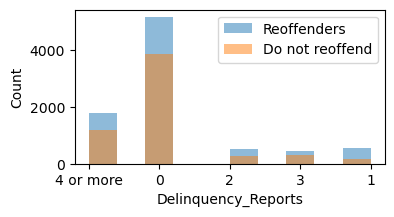

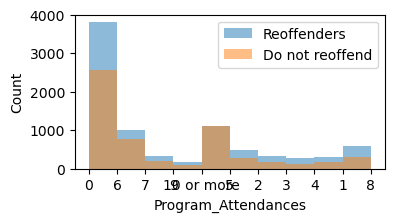

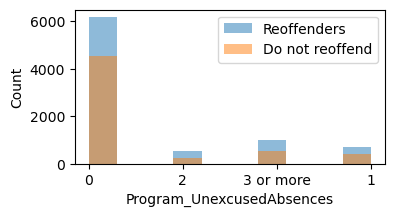

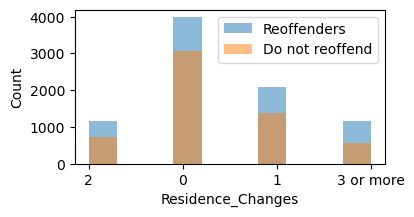

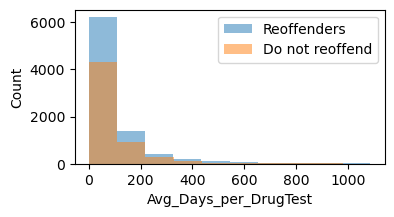

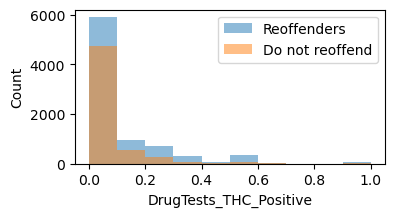

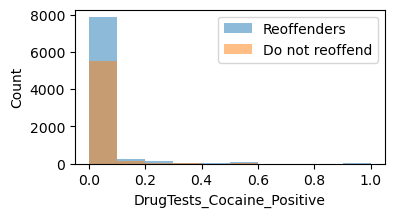

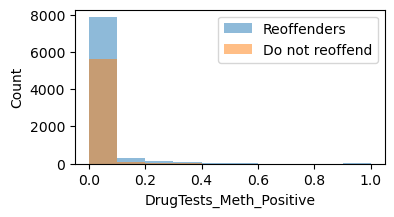

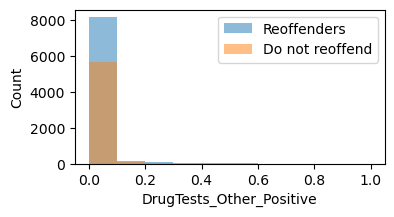

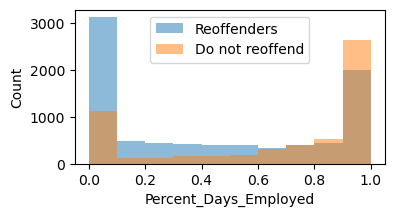

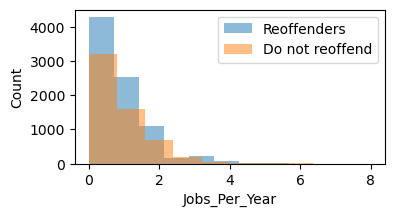

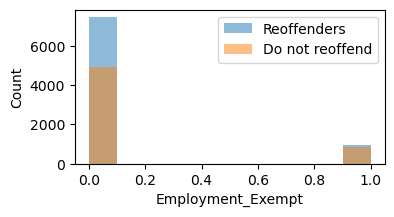

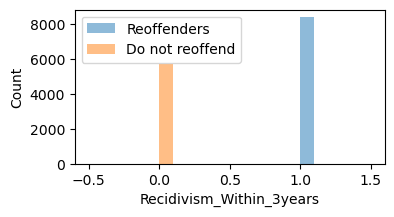

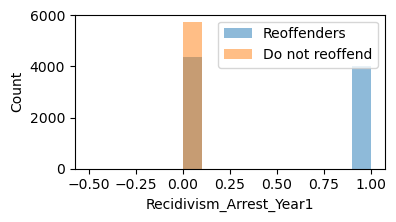

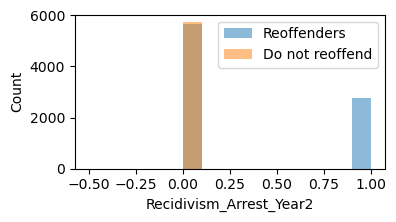

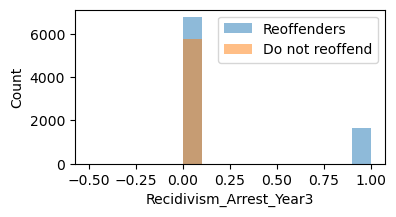

In [48]:
for col in df.columns[1:-1]: # Skip ID and train_flag
    fig = plt.figure(figsize=(4, 2))
    plt.hist(1*df[y == True][col], label='Reoffenders', alpha=0.5)
    plt.hist(1*df[y == False][col], label='Do not reoffend', alpha=0.5)
    plt.legend()
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()        

# Two Dimensional Data Exploration

In [53]:
fig = sns.pairplot(df)

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_functio

In [54]:
fig.savefig("Pairplots.png")

C:\Users\black\AppData\Local\Temp\ipykernel_18440\4198761842.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

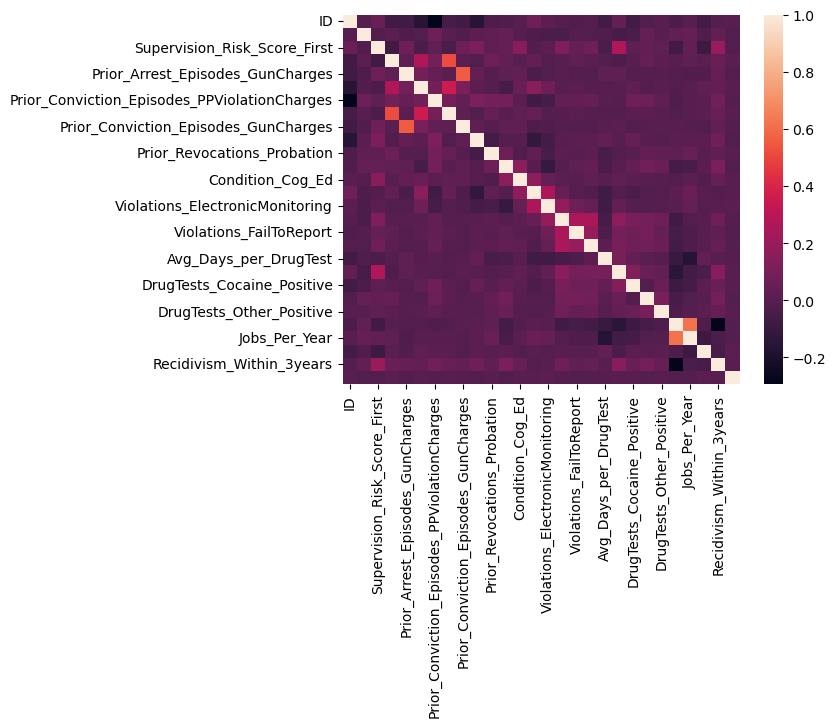

In [67]:
#Correlation of numeric features
sns.heatmap(df.corr())

# Model 0: Baseline (Dummy Classifier)

In [46]:
#Relatively speaking, they are balanced
#But there is a clear majority, so  let's look at the baseline
model_baseline= DummyClassifier(strategy = "most_frequent").fit(X_train, y_train)

#If this is the baseline, then the maximum possible predictions were not that good apparently. Good to know
print("Baseline Brier Score: " + str(brier_score_loss(y_test, model_baseline.predict_proba(X_test)[:, 1])))

Baseline Brier Score: 0.4051246537396122


# Model 1: XGBoost

I'm not going to fool around with less common models here. We already have our baseline, let's see how it compares to a legitimate, commonly used model in the industry with no additional adjustments yet.

In [45]:
import xgboost as xgb

In [46]:
params = {'max_depth': [3, 5, 10, 20, 50, 100],
         'min_child_weight': [.01, .1, 1, 10, 100],
         'alpha': [.01, .5, 1], 
         'eta': [.01, .1, .2, .3]}

model_xgb = RandomizedSearchCV(xgb.XGBClassifier(eval_metric = 'auc', num_class=1, use_label_encoder=False), 
                         params)

In [47]:
#Dumb warnings about some deprecated int data type in the dataframe (it's not even deprecated yet)
import warnings

In [48]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*pandas.Int64Index is deprecated.*")
    model_xgb.fit(X_train_enc, y_train)

In [50]:
print("XGB Brier Score: " + str(brier_score_loss(y_test, model_xgb.best_estimator_.predict_proba(X_test_enc)[:, 1])))

XGB Brier Score: 0.19290606279991604


C:\Users\black\anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [51]:
#That's quite a good result!
#addtl param tuning around the minimum:
print(model_xgb.best_params_)
params = {'max_depth': [3, 5, 10, 20, 50, 100],
         'min_child_weight': [.01, .1, 1, 10, 100],
         'alpha': [.01, .3, .5, .7, 1], 
         'eta': [.01, .02, .05, .1, .2]}

{'min_child_weight': 10, 'max_depth': 10, 'eta': 0.01, 'alpha': 1}


In [52]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*pandas.Int64Index is deprecated.*")
    model_xgb.fit(X_train_enc, y_train)

In [53]:
#It's even better!
#I will stop hyperparemeter tuning for now
print("XGB Brier Score 2: " + str(brier_score_loss(y_test, model_xgb.best_estimator_.predict_proba(X_test_enc)[:, 1])))

XGB Brier Score 2: 0.1765932441126029


C:\Users\black\anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


C:\Users\black\anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


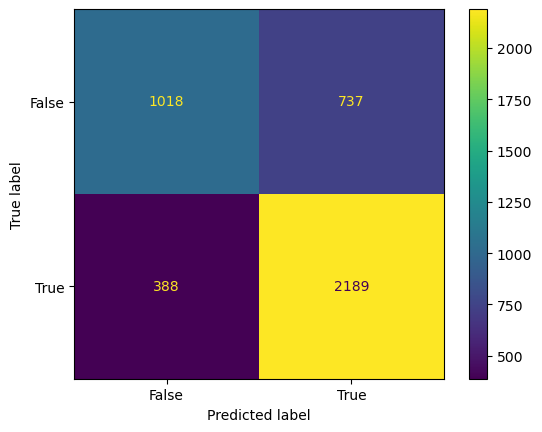

In [54]:
#Not bad
cm = confusion_matrix(y_test, model_xgb.best_estimator_.predict(X_test_enc))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()

# Model 2: Ridge Classification

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [24]:
#params
params = {'alpha': [.01, .1, 1, 10, 100]}
model_ridge = GridSearchCV(Ridge(), param_grid = params)

In [25]:
model_ridge.fit(X_train_enc, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [30]:
print(model_ridge.best_params_)

{'alpha': 1}


In [29]:
print("Ridge Brier Score: " + str(brier_score_loss(y_test, np.exp(model_ridge.best_estimator_.predict(X_test_enc))/ np.sum(np.exp(model_ridge.best_estimator_.predict(X_test_enc))))))

Ridge Brier Score: 0.594576546213642


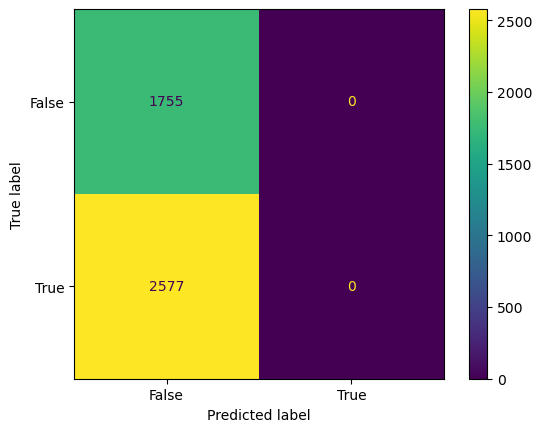

In [34]:
cm = confusion_matrix(y_test, np.round(np.exp(model_ridge.best_estimator_.predict(X_test_enc))/ np.sum(np.exp(model_ridge.best_estimator_.predict(X_test_enc))), 0))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()

###### conclusion: this probably will not work

# Model 3: AdaBoost Classification

In [36]:
from sklearn.ensemble import AdaBoostClassifier

In [41]:
params = {'learning_rate': [1e-7, 1e-5, 1e-3]}
model_ada = GridSearchCV(AdaBoostClassifier(), param_grid = params)

In [42]:
model_ada.fit(X_train_enc, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1e-07, 1e-05, 0.001]})

In [43]:
#not bad at all, XGBoost was still better though
print("ADA Brier Score: " + str(brier_score_loss(y_test, model_ada.best_estimator_.predict_proba(X_test_enc)[:, 1])))

ADA Brier Score: 0.21760775937714114


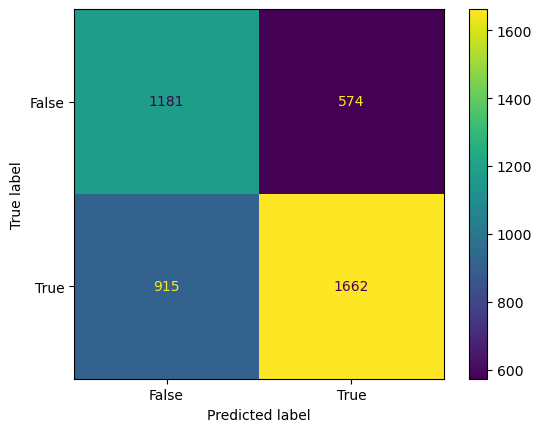

In [66]:
#Not bad
cm = confusion_matrix(y_test, model_ada.best_estimator_.predict(X_test_enc))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()

# Findings

### Here are some conclusions from the best two models

Text(0.5, 0, 'Feature Importance Most Important for Recidivism- XGB model')

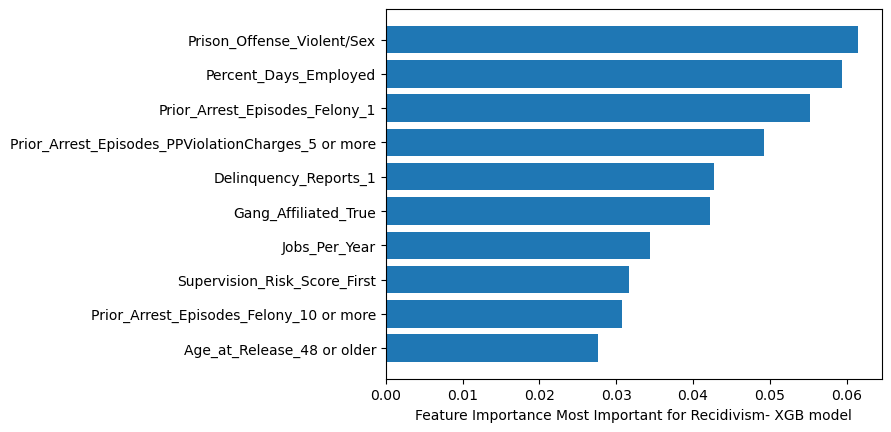

In [62]:
idx = model_xgb.best_estimator_.feature_importances_.argsort()[-10:]
plt.barh(X_train_enc.columns[idx], model_xgb.best_estimator_.feature_importances_[idx])
plt.xlabel("Feature Importance Most Important for Recidivism- XGB model")

Text(0.5, 0, 'Feature Importance Most Important for Recidivism- ADAboost model')

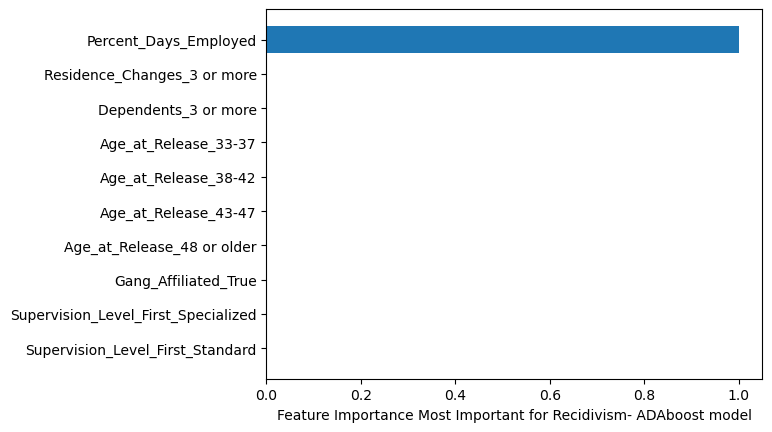

In [65]:
idx = model_ada.best_estimator_.feature_importances_.argsort()[-10:]
plt.barh(X_train_enc.columns[idx], model_ada.best_estimator_.feature_importances_[idx])
plt.xlabel("Feature Importance Most Important for Recidivism- ADAboost model")

Very interesting result, the AdaBoost model is only using Percent Days Employed.

In Part 2 of this experiment, I will try using only percent days employed with some model and see if that works.

# Conclusions

1. We are able to produce a model using XGboost that has a brier loss score of 0.1765932441126029. Which is pretty close to the competition models. Adaboost produces a brier loss of 0.21760775937714114 with only one coefficient, making it a very shallow linear Adaboost model. As far as the raw number of correct classifications. The XGboost model, which is the superior one, has about a 3:1 ratio of correct guess:incorrect guesses in terms of both false positive rate and false negative rate.
2. The most important factors for determining recidivism are related to how many jobs the person has had, and a certain degree of red flags in their record such as especially heinous crimes (violent/sex crimes), gang affiliation, delinquency reports, and supervision risk score.
3. It is especially notable, that we were able to find a model with brier score of around .22 that was only based on the percentage of days a prisoner was employed and nothing else.

This model is probably usable in some real world application the way it is at the moment. In part 2, we will discover whether it's usable when it has >90% certainty of recidivity or non-recidividity



Things to do for part 2:
1. Look at the recidivism rates for just the most certain predicted probabilities
2. Train a model on just the most important features